In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
# Load the cleaned data
df = pd.read_csv('../data/processed/new_data.csv')
df.head()

,step,type,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud
0,1,PAYMENT,9839.64,170136.0,160296.36,0.0,0.0,0
1,1,PAYMENT,1864.28,21249.0,19384.72,0.0,0.0,0
2,1,TRANSFER,181.00,181.0,0.00,0.0,0.0,1
3,1,CASH_OUT,181.00,181.0,0.00,21182.0,0.0,1
4,1,PAYMENT,11668.14,41554.0,29885.86,0.0,0.0,0


In [4]:
print(df.shape)
print(df['isFraud'].value_counts(normalize=True) * 100)

(6362077, 8)
isFraud
0    99.871158
1     0.128842
Name: proportion, dtype: float64


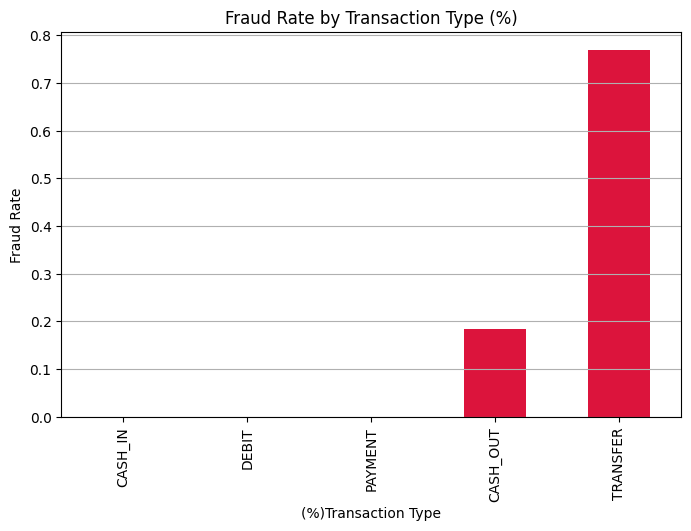

In [5]:
# Fraud rate per transaction type
fraud_rate = df.groupby('type')['isFraud'].mean() * 100

# Horizontal bar plot
plt.figure(figsize=(8, 5))
fraud_rate.sort_values().plot(kind='bar', color='crimson')
plt.title("Fraud Rate by Transaction Type (%)")
plt.xlabel("(%)Transaction Type")
plt.ylabel("Fraud Rate")
plt.grid(True, axis='y')
plt.show()

Based on this plot:
`TRANSFER` has the most risk.
`CASH_OUT` is also risky.

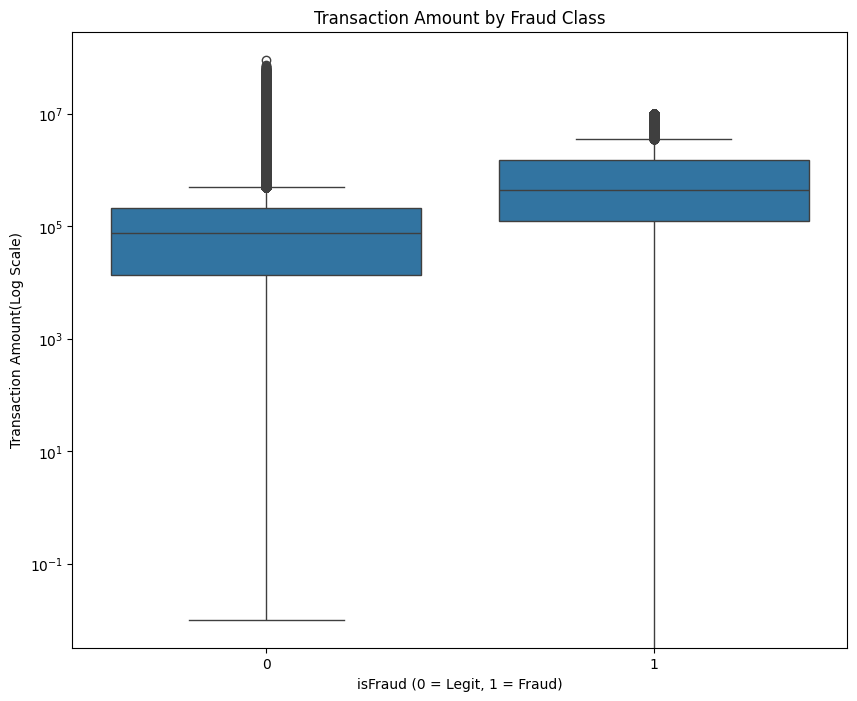

In [6]:
plt.figure(figsize=(10, 8))
sns.boxplot(data=df, x='isFraud', y='amount')
plt.yscale('log')
plt.title('Transaction Amount by Fraud Class')
plt.xlabel('isFraud (0 = Legit, 1 = Fraud)')
plt.ylabel('Transaction Amount(Log Scale)')
plt.show()

Fraud tends to involve larger transactions, but not all large transactions are fraud.

Use this pattern as one feature — not a hard rule.

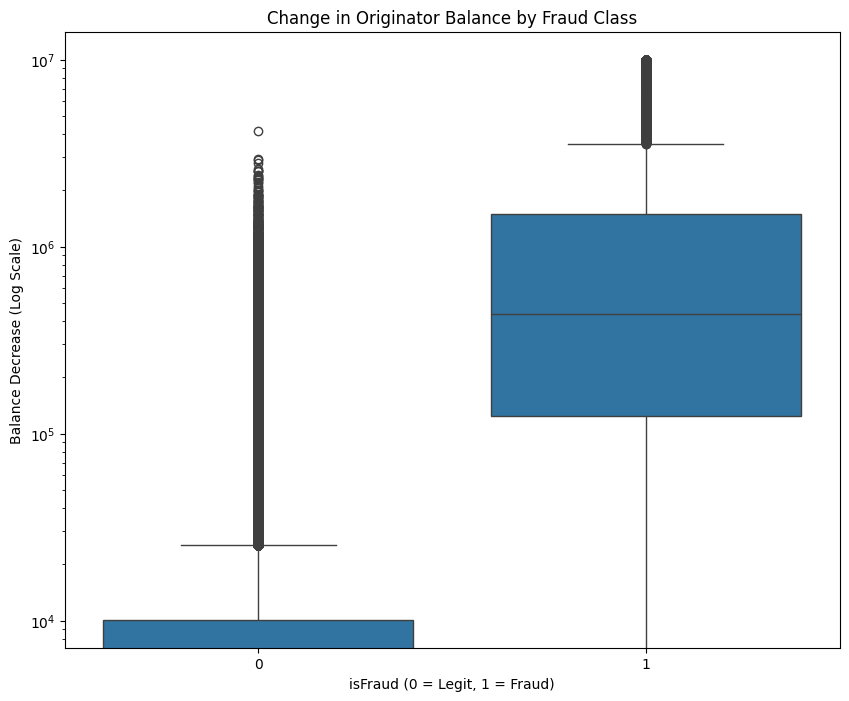

In [7]:
df['diff_balanceOrig'] = df['oldbalanceOrg'] - df['newbalanceOrig']

plt.figure(figsize=(10, 8))
sns.boxplot(data=df, x='isFraud', y='diff_balanceOrig')
plt.yscale('log')
plt.title('Change in Originator Balance by Fraud Class')
plt.xlabel('isFraud (0 = Legit, 1 = Fraud)')
plt.ylabel('Balance Decrease (Log Scale)')
plt.show()  

 Fraud transactions often involve larger deductions, supporting the idea that fraudsters try to extract maximum value.

 Some legit users also move big money, so amount or balance change alone can’t classify fraud.

We now have another strong signal — `diff_balanceOrig` helps differentiate fraud, especially combined with `amount` and `type`.

But it must be used with other features to avoid misclassifying legit high-value transfers.

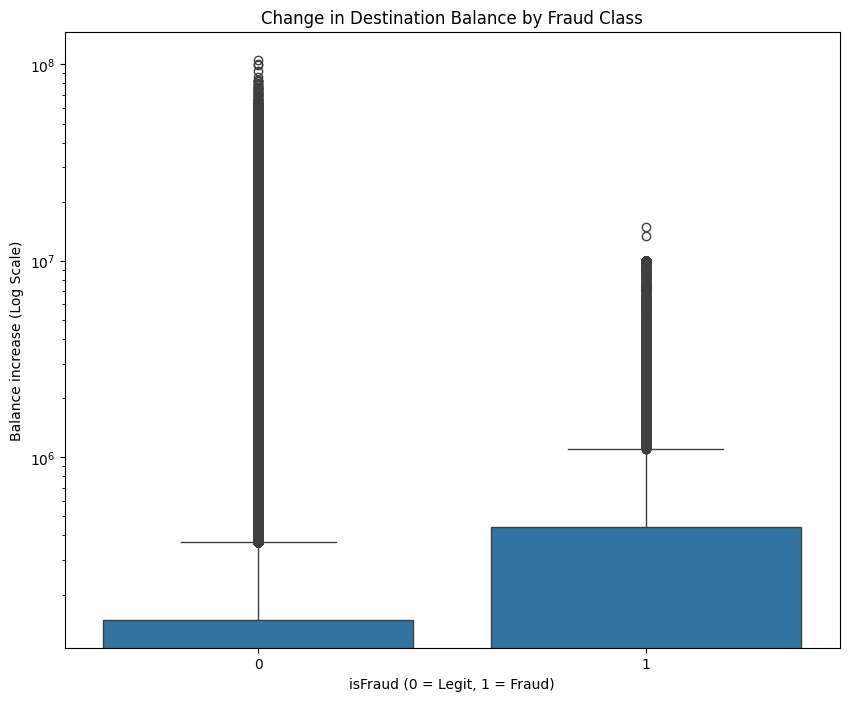

In [8]:
df['diff_balanceDest'] = df['newbalanceDest'] - df['oldbalanceDest']

plt.figure(figsize=(10,8))
sns.boxplot(data=df, x='isFraud', y='diff_balanceDest')
plt.yscale('log')
plt.title('Change in Destination Balance by Fraud Class')
plt.xlabel('isFraud (0 = Legit, 1 = Fraud)')
plt.ylabel('Balance increase (Log Scale)')
plt.show()

`diff_balanceDest` is not reliable by itself to detect fraud.
It adds minor value when used in combination with other features, especially when `type` is `TRANSFER` or `CASH_OUT`.

In [9]:
fraud_by_step = df[df['isFraud'] == 1]['step'].value_counts().sort_index()
nonfraud_by_step = df[df['isFraud'] == 0]['step'].value_counts().sort_index()

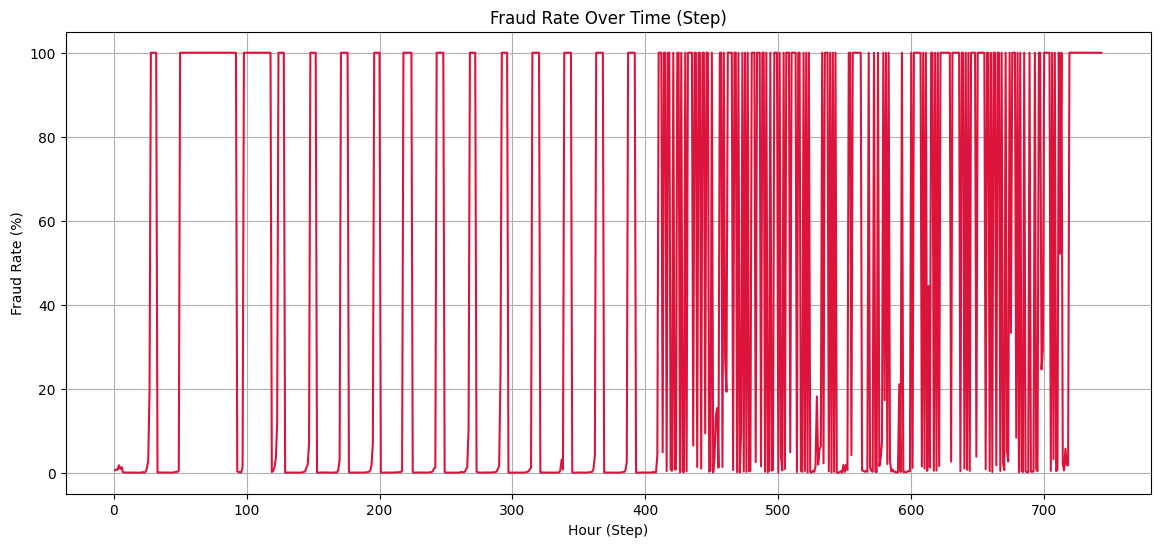

In [10]:
# Group by step and calculate fraud rate
fraud_rate_step = df.groupby('step')['isFraud'].mean() * 100

# Plot fraud rate over time
plt.figure(figsize=(14, 6))
plt.plot(fraud_rate_step.index, fraud_rate_step.values, color='crimson')
plt.title('Fraud Rate Over Time (Step)')
plt.xlabel('Hour (Step)')
plt.ylabel('Fraud Rate (%)')
plt.grid(True)
plt.show()

In [24]:
df['late_phase'] = df['step'] > 400

We already saw fraud activity increases in later steps. This binary feature gives the model a simple way to leverage that.

In [27]:
df['day'] = df['step'] // 24

In [28]:
df['hour'] = df['step'] % 24
df['hour']

0           1
1           1
2           1
3           1
4           1
           ..
6362072    23
6362073    23
6362074    23
6362075    23
6362076    23
Name: hour, Length: 6362077, dtype: int64

In [34]:
output_path = '../data/processed/eda_data.csv'
df.to_csv(output_path, index=False)